In [1]:
import jax.random as jr
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import optax as ox
import pandas as pd
from jax import jit
from jax.config import config
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import gpjax as gpx

# Enable Float64 for more stable matrix inversions.
config.update("jax_enable_x64", True)
key = jr.PRNGKey(123)
plt.style.use('./gpjax.mplstyle')
cols = mpl.rcParams['axes.prop_cycle'].by_key()['color']

# UCI Data Benchmarking

In this notebook, we will show how to apply GPJax on a benchmark UCI regression
problem. These kind of tasks are often used in the research community to benchmark
and assess new techniques against those already in the literature. Much of the code
contained in this notebook can be adapted to applied problems concerning datasets
other than the one presented here.

## Data Loading

We'll be using the
[Yacht](https://archive.ics.uci.edu/ml/datasets/yacht+hydrodynamics) dataset from
the UCI machine learning data repository. Each observation describes the
hydrodynamic performance of a yacht through its resistance. The dataset contains 6
covariates and a single positive, real valued response variable. There are 308
observations in the dataset, so we can comfortably use a conjugate regression
Gaussian process here (for more more details, checkout the
[Regression notebook](https://gpjax.readthedocs.io/en/latest/nbs/regression.html)).

In [2]:
yacht = pd.read_fwf("data/yacht_hydrodynamics.data", header=None).values[:-1, :]
X = yacht[:, :-1]
y = yacht[:, -1].reshape(-1, 1)

## Preprocessing

With a dataset loaded, we'll now preprocess it such that it is more amenable to
modelling with a Gaussian process.

### Data Partitioning

We'll first partition our data into a _training_ and _testing_ split. We'll fit our
Gaussian process to the training data and evaluate its performance on the test data.
This allows us to investigate how effectively our Gaussian process generalises to
out-of-sample datapoints and ensure that we are not overfitting. We'll hold 30% of
our data back for testing purposes.

In [3]:
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=42)

### Response Variable

We'll now process our response variable $\mathbf{y}$. As the below plots show, the
data has a very long tail and is certainly not Gaussian. However, we would like to
model a Gaussian response variable so that we can adopt a Gaussian likelihood
function and leverage the model's conjugacy. To achieve this, we'll first log-scale
the data, to bring the long right tail in closer to the data's mean. We'll then
standardise the data such that is distributed according to a unit normal
distribution. Both of these transformations are invertible through the log-normal
expectation and variance formulae and the the inverse standardisation identity,
should we ever need our model's predictions to be back on the scale of the
original dataset.

For transforming both the input and response variable, all transformations will be
done with respect to the training data where relevant.

In [4]:
log_ytr = np.log(ytr)
log_yte = np.log(yte)

y_scaler = StandardScaler().fit(log_ytr)
scaled_ytr = y_scaler.transform(log_ytr)
scaled_yte = y_scaler.transform(log_yte)

We can see the effect of these transformations in the below three panels.

Text(0.5, 1.0, 'scaled log(y)')

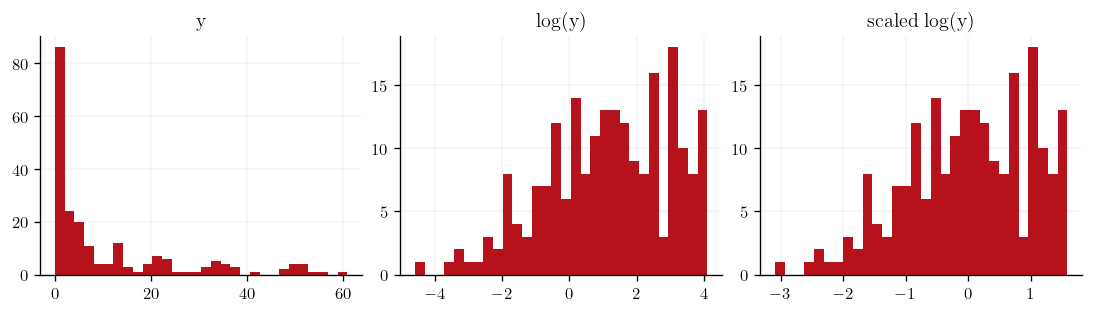

In [7]:
fig, ax = plt.subplots(ncols=3, figsize=(9, 2.5))
ax[0].hist(ytr, bins=30, color=cols[1])
ax[0].set_title("y")
ax[1].hist(log_ytr, bins=30, color=cols[1])
ax[1].set_title("log(y)")
ax[2].hist(scaled_ytr, bins=30, color=cols[1])
ax[2].set_title("scaled log(y)")

### Input Variable

We'll now transform our input variable $\mathbf{X}$ to be distributed according to a
unit Gaussian.

In [8]:
x_scaler = StandardScaler().fit(Xtr)
scaled_Xtr = x_scaler.transform(Xtr)
scaled_Xte = x_scaler.transform(Xte)

## Model fitting

With data now loaded and preprocessed, we'll proceed to defining a Gaussian process
model and optimising its parameters. This notebook purposefully does not go into
great detail on this process, so please see notebooks such as the
[Regression notebook](https://gpjax.readthedocs.io/en/latest/nbs/regression.html)
and
[Classification notebook](https://gpjax.readthedocs.io/en/latest/nbs/classification.html)
for further information.

### Model specification

We'll use a radial basis function kernel to parameterise the Gaussian process in this
notebook. As we have 5 covariates, we'll assign each covariate its own lengthscale
parameter. This form of kernel is commonly known as an automatic relevance
determination (ARD) kernel.

In practice, the exact form of kernel used should be selected such that it
represents your understanding of the data. For example, if you were to model
temperature; a process that we know to be periodic, then you would likely wish to
select a periodic kernel. Having _Gaussian-ised_ our data somewhat, we'll also adopt
a Gaussian likelihood function.

In [9]:
n_train, n_covariates = scaled_Xtr.shape
kernel = gpx.RBF(active_dims=list(range(n_covariates)))
meanf = gpx.mean_functions.Zero()
prior = gpx.Prior(mean_function=meanf, kernel=kernel)

likelihood = gpx.Gaussian(num_datapoints=n_train)

posterior = prior * likelihood

### Model Optimisation

With a model now defined, we can proceed to optimise the hyperparameters of our
model using Optax.

In [10]:
training_data = gpx.Dataset(X=scaled_Xtr, y=scaled_ytr)

negative_mll = jit(gpx.ConjugateMLL(negative=True))
optimiser = ox.adamw(0.05)

opt_posterior, history = gpx.fit(
    model=posterior,
    objective=negative_mll,
    train_data=training_data,
    optim=ox.adamw(learning_rate=0.05),
    num_iters=500,
)

/Users/tompinder/Development/JaxGPDevs/GPJax/gpjax/fit.py:190: UserWarning: Objective is jit-compiled. Please ensure that the objective is of type gpjax.Objective.
  warn("Objective is jit-compiled. Please ensure that the objective is of type gpjax.Objective.")


  0%|          | 0/500 [00:00<?, ?it/s]

## Prediction

With an optimal set of parameters learned, we can make predictions on the set of
data that we held back right at the start. We'll do this in the usual way by first
computing the latent function's distribution before computing the predictive
posterior distribution.

In [11]:
latent_dist = opt_posterior(scaled_Xte, training_data)
predictive_dist = likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_stddev = predictive_dist.stddev()

## Evaluation

We'll now show how the performance of our Gaussian process can be evaluated by
numerically and visually.

### Metrics

To numerically assess the performance of our model, two commonly used metrics are
root mean squared error (RMSE) and the R2 coefficient. RMSE is simply the square
root of the squared difference between predictions and actuals. A value of 0 for
this metric implies that our model has 0 generalisation error on the test set. R2
measures the amount of variation within the data that is explained by the model.
This can be useful when designing variance reduction methods such as control
variates as it allows you to understand what proportion of the data's variance will
be soaked up. A perfect model here would score 1 for R2 score, whereas predicting
the data's mean would score 0 and models doing worse than simple mean predictions
can score less than 0.

In [12]:
rmse = mean_squared_error(y_true=scaled_yte.squeeze(), y_pred=predictive_mean)
r2 = r2_score(y_true=scaled_yte.squeeze(), y_pred=predictive_mean)
print(f"Results:\n\tRMSE: {rmse: .4f}\n\tR2: {r2: .2f}")

Results:
	RMSE:  0.0058
	R2:  0.99


Both of these metrics seem very promising, so, based off these, we can be quite
happy that our first attempt at modelling the Yacht data is promising.

### Diagnostic plots

To accompany the above metrics, we can also produce residual plots to explore
exactly where our model's shortcomings lie. If we define a residual as the true
value minus the prediction, then we can produce three plots:

1. Predictions vs. actuals.
2. Predictions vs. residuals.
3. Residual density.

The first plot allows us to explore if our model struggles to predict well for
larger or smaller values by observing where the model deviates more from the line
$y=x$. In the second plot we can inspect whether or not there were outliers or
structure within the errors of our model. A well-performing model would have
predictions close to and symmetrically distributed either side of $y=0$. Such a
plot can be useful for diagnosing heteroscedasticity. Finally, by plotting a
histogram of our residuals we can observe whether or not there is any skew to
our residuals.

Text(0.5, 1.0, 'Residuals')

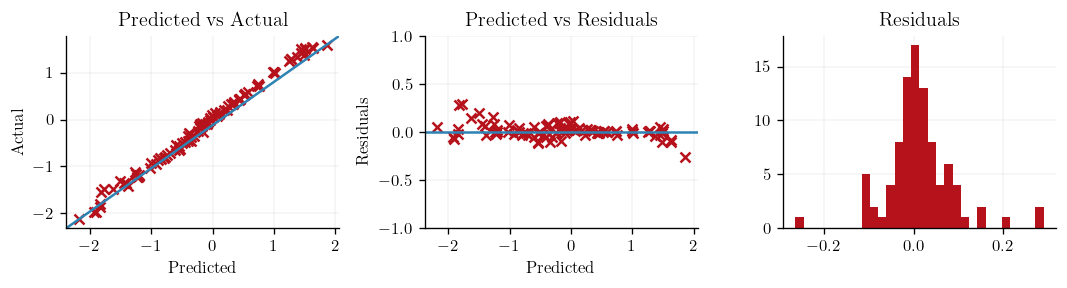

In [14]:
residuals = scaled_yte.squeeze() - predictive_mean

fig, ax = plt.subplots(ncols=3, figsize=(9, 2.5), tight_layout=True)

ax[0].scatter(predictive_mean, scaled_yte.squeeze(), color=cols[1])
ax[0].plot([0, 1], [0, 1], color=cols[0], transform=ax[0].transAxes)
ax[0].set(xlabel="Predicted", ylabel="Actual", title="Predicted vs Actual")

ax[1].scatter(predictive_mean.squeeze(), residuals, color=cols[1])
ax[1].plot([0, 1], [0.5, 0.5], color=cols[0], transform=ax[1].transAxes)
ax[1].set_ylim([-1.0, 1.0])
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")

ax[2].hist(np.asarray(residuals), bins=30, color=cols[1])
ax[2].set_title("Residuals")

From this, we can see that our model is struggling to predict the smallest values
of the Yacht's hydrodynamic and performs increasingly well as the Yacht's
hydrodynamic performance increases. This is likely due to the original data's heavy
right-skew, and successive modelling attempts may wish to introduce a
heteroscedastic likelihood function that would enable more flexible modelling of
the smaller response values.

## System configuration

In [ ]:
%reload_ext watermark
%watermark -n -u -v -iv -w -a 'Thomas Pinder'